In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment
from inxss import PsiMask


import matplotlib.pyplot as plt

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator

/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_AFM_data_2023Aug01.pt')

In [3]:
data.keys()

dict_keys(['Syy', 'Szz', 'S', 'w_grid', 'q_grid', 'params'])

In [4]:
w_grid = data['w_grid']
q_grid = data['q_grid']
Syy_grid = data['Syy']
Szz_grid = data['Szz']

In [5]:
# Syy_func = RegularGridInterpolator(
#     [np.sort(np.unique(_q)) for _q in q_grid.numpy()[:2]] + [w_grid.numpy(),], 
#     Syy_grid[0].reshape(150, 101, 101).permute(1,2,0).numpy())

# Szz_func = RegularGridInterpolator(
#     [np.sort(np.unique(_q)) for _q in q_grid.numpy()[:2]] + [w_grid.numpy(),], 
#     Szz_grid[0].reshape(150, 101, 101).permute(1,2,0).numpy())

Syy_func = RegularGridInterpolator(
    [np.sort(np.unique(_q)) for _q in q_grid.numpy()[:2]] + [w_grid.numpy(),], 
    np.ones((101,101,150)), bounds_error=False, fill_value=0.)

Szz_func = RegularGridInterpolator(
    [np.sort(np.unique(_q)) for _q in q_grid.numpy()[:2]] + [w_grid.numpy(),], 
    np.ones((101,101,150)), bounds_error=False, fill_value=0.)

In [6]:
coords = np.moveaxis(np.stack(np.meshgrid(np.sort(np.unique(q_grid.numpy()[0])), np.sort(np.unique(q_grid.numpy()[1])), w_grid.numpy(), indexing='ij')), 0, -1)

In [7]:
Syy_out = Syy_func(coords)

In [8]:
np.allclose(Syy_grid.numpy()[0].reshape(101, 101, 150), Syy_out)

False

In [9]:
map_path = '/pscratch/sd/z/zhantao/inxs_steering/La2NiO4_bool'
psi_mask = PsiMask(map_path, scale_factor=0.5, device='cpu', preload=False)

In [30]:
# coords = np.concatenate(
#     [
#      np.tile(q_grid, (w_grid.shape[0], 1, 1)).transpose(0, 2, 1), 
#      np.repeat(w_grid[:,None,None], q_grid.shape[1], axis=1)
#      ], axis=-1
# )

coords = psi_mask.hklw_grid

# coords = torch.moveaxis(
#             torch.stack(torch.meshgrid(
#                 torch.linspace(-4,4,50), torch.linspace(-4,4,50), torch.linspace(-15,15,50), torch.linspace(0,260,50), indexing='ij'), dim=0), 0, -1)

In [31]:
S_out = calc_Sqw_from_Syy_Szz(coords, Syy_func, Szz_func)

Text(0, 0.5, 'K')

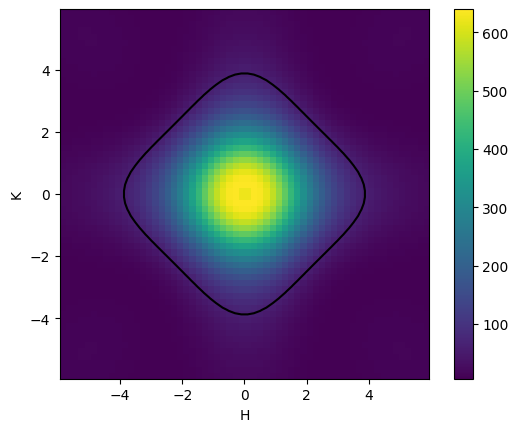

In [36]:
plt.imshow((S_out.sum(axis=-1).sum(axis=-1).reshape(60,60)), 
    extent=[coords[...,0].min(),coords[...,0].max(),coords[...,1].min(),coords[...,1].max()])
plt.colorbar()
plt.contour(*np.meshgrid(psi_mask.h_grid, psi_mask.k_grid), (S_out.sum(axis=-1).sum(axis=-1)), 
    levels=[0.1 * S_out.sum(axis=-1).sum(axis=-1).max(),],
    colors='k', )
plt.xlabel('H')
plt.ylabel('K')

In [67]:
q_grid.shape

torch.Size([3, 10201])

In [72]:
exp = SimulatedExperiment(q_grid, w_grid, Syy_grid[0], Szz_grid[0])

In [73]:
S_out = exp.get_S(coords)

In [74]:
np.allclose(data['S'][0], S_out)

True

In [75]:
torch.cat([exp.full_grid, torch.zeros_like(exp.full_grid[...,0,None])], dim=-1)

tensor([[[[0.0000e+00, 0.0000e+00, 5.0000e-01, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.5000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 2.5000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 1.4750e+02, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.4850e+02, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.4950e+02, 0.0000e+00]],

         [[0.0000e+00, 5.0000e-03, 5.0000e-01, 0.0000e+00],
          [0.0000e+00, 5.0000e-03, 1.5000e+00, 0.0000e+00],
          [0.0000e+00, 5.0000e-03, 2.5000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 5.0000e-03, 1.4750e+02, 0.0000e+00],
          [0.0000e+00, 5.0000e-03, 1.4850e+02, 0.0000e+00],
          [0.0000e+00, 5.0000e-03, 1.4950e+02, 0.0000e+00]],

         [[0.0000e+00, 1.0000e-02, 5.0000e-01, 0.0000e+00],
          [0.0000e+00, 1.0000e-02, 1.5000e+00, 0.0000e+00],
          [0.0000e+00, 1.0000e-02, 2.5000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 1.0000e-02, 1.4750e+02, 0.00

In [78]:
exp.full_grid.shape

torch.Size([101, 101, 150, 3])

In [79]:
S_out = exp.get_S(torch.cat([exp.full_grid[...,:2], torch.zeros_like(exp.full_grid[...,0,None]), exp.full_grid[...,2:3]], dim=-1).numpy()).reshape(-1, 150)

In [81]:
np.allclose(data['S'][0], S_out.T)

True